In [1]:
import argparse
import dpkt
import socket
import os
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

X = []
Y = []

ModuleNotFoundError: No module named 'Framework'

In [2]:
def sending_rate(path,delta_t):
    
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and ".pcap" in f ]
    
    for file in onlyfiles:
        id = 1
        f = open(path+"/"+file,'rb')

        pcap = dpkt.pcap.Reader(f)

        #ts: timestamp
        #buf: packet data length

        t = 0
        start_t = -1
        pkts = pcap.readpkts()
        total_sending_rate = []

        #Total do LINK
        #Para cada tupla e necessario 1 unico caso.


        #Dict to map all connections: (tcp_tuple, list_data_connection)
        connections = {}
        qtd_2 = 0
        for i in range(len(pkts)):
            qtd_2 += 1
            try:
                if(start_t == -1):
                    start_t = pkts[i][0]

                eth = dpkt.ethernet.Ethernet( pkts[i][1] )	

                ip = eth.data
                tcp = ip.data

                src_ip = socket.inet_ntoa(ip.src)
                dst_ip = socket.inet_ntoa(ip.dst)

                src_port = tcp.sport
                dst_port = tcp.dport

                tcp_tuple = (src_ip,src_port,dst_ip,dst_port)

                #Solucao temporaria pra evitar pegar dados da porta ftp de controle de dados
                #Talvez seja necessario para pegar quantidade de retransminssoes
                #Mas imagino que nao seja, devido a vontade de querer saber apenas a quantidade massiva de dados
                #que esteja transportando
                if(src_ip > dst_ip or dst_port == 2121 or src_port == 2121):
                    continue

                try:
                    data_list = connections[tcp_tuple]
                    data_list.append( (pkts[i][0], pkts[i][1] ) )
                    connections[tcp_tuple] = data_list

                except:
                    data_list = []
                    data_list.append( (pkts[i][0], pkts[i][1] ) )

                    connections[tcp_tuple] = data_list


            # total_sending_rate.append(sum_i)
            except Exception as e:
                print(e)
                print("ERRO NO PACOTE: ",i)

        maxi = 0
        #Faltou o tempo de cada pacote.
        connections_sending_rate = {}
        times = []
        times_not_used = []
        for key in connections:
            # print(key)
            data = connections[key]
            t = -1

            for i in range(len(data)):

                if(t == -1):
                    t = data[i][0]

                if(data[i][0] <= t+delta_t):
                    times_not_used.append(data[i][0]-start_t)
                    continue

                t = data[i][0]
                time = []
                time.append(t-start_t)

                eth = dpkt.ethernet.Ethernet( data[i][1] )

                ip = eth.data

                tcp = ip.data
                maxi = max(maxi,len(tcp.data))

                sum_i = len(tcp.data)*8.0

                while(i+1 < len(data) and data[i+1][0] <= t+delta_t):
                    time.append(data[i+1][0]-start_t)
                    eth_i = dpkt.ethernet.Ethernet( data[i+1][1] )
                    ip_i = eth_i.data	
                    tcp_i = ip_i.data
                    sum_i += len(tcp_i.data)*8.0
                    maxi = max(maxi,len(tcp_i.data))
                    i+=1
                times.append(time)
                # print(i,t + delta_t- start_t,sum_i)
                #Faltou agregar o tempo necessario para todos
                try:
                    sums = connections_sending_rate[key]
                    sums.append( ( t+delta_t- start_t ,sum_i/(delta_t*1000000) ) )
                except:
                    sums = []
                    sums.append( ( t+delta_t- start_t ,sum_i/(delta_t*1000000)))
                    connections_sending_rate[key] = sums

                t = t+delta_t
        f.close()


        # for time in times:
        # 	print(len(time),time)
        # print("NOT USED", times_not_used)


        #Melhorar o plot.

        val = 0

        data = []
        for key in connections_sending_rate:
            for x in connections_sending_rate[key]:
                data_json = {"src":key[0]}
                data_json.update({"sport":key[1]})
                data_json.update({"dest":key[2]})
                data_json.update({"dport":key[3]})
                data_json.update({'time':x[0]})
                data_json.update({'rate':x[1]})
                data_json.update({'id':id})
                data.append(data_json)
        id = id + 1
        return pd.DataFrame(data)


In [3]:
mypath = "/home/rodrigoluna/Área de Trabalho/UFRJ/TCC/Framework/sw1"
df = sending_rate(mypath,0.17355421)
print(df)

          src  sport      dest  dport        time       rate  id
0    10.0.0.1  54017  10.0.0.4  59384    0.628437  10.412332   1
1    10.0.0.1  54017  10.0.0.4  59384    0.976293   9.611383   1
2    10.0.0.1  54017  10.0.0.4  59384    1.324401   9.678129   1
3    10.0.0.1  54017  10.0.0.4  59384    1.673694   9.611383   1
4    10.0.0.1  54017  10.0.0.4  59384    2.021567   9.678129   1
..        ...    ...       ...    ...         ...        ...  ..
335  10.0.0.1  54017  10.0.0.4  59384  117.689681   9.678129   1
336  10.0.0.1  54017  10.0.0.4  59384  118.038499   9.611383   1
337  10.0.0.1  54017  10.0.0.4  59384  118.386347   9.678129   1
338  10.0.0.1  54017  10.0.0.4  59384  118.734966   9.678129   1
339  10.0.0.1  54017  10.0.0.4  59384  119.084922   3.137049   1

[340 rows x 7 columns]


AttributeError: 'AxesSubplot' object has no attribute 'show'

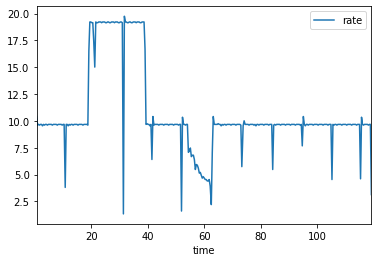

In [5]:
df.plot(x='time',y = 'rate').show()

In [11]:
def plot(x,y, x_label,y_label):
	import matplotlib.pyplot as plt
	plt.cla()
	arrays = [ np.array(_y) for _y in y]
	try:

		means = [np.mean(k) for k in zip(*arrays)]
		
	except:
		means = arrays[0]

	arrays = [ np.array(_x) for _x in x]
	try:

		time_means = [np.mean(k) for k in zip(*arrays)]
		
	except:
		time_means = arrays[0]

	
	
	means = means.astype(float)
	# plt.ylim(min(means),np.mean(means) + np.std(means))
	plt.plot(time_means,means)
	plt.ylabel(y_label)
	plt.xlabel("Tempo ({})".format(x_label))
		
	plt.show()
	return plt



def get_num(x):
    val = ''
    for ele in x:
        if(ele.isdigit() or ele == '.'):
            val += ele
        else:
            break
    return float(val)

def rate(val):
    number = get_num(val)
    if("K" in val):
        number *= 1000
    elif("M" in val):
        number *= 1000000
    elif("G" in val):
        number *= 1000000000
    return number

def mrtt_to_secs(val):
    number = get_num(val)
    number *= 0.001
    return number
    
    
def format_bbrColumns(df):
    df['bw'] = df['bw'].apply(lambda x: rate(x) )
    df['mrtt'] = df['mrtt'].apply(lambda x: mrtt_to_secs(x) ) 
    return df.fillna(0)


def bbrParser(path):
    data = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and "bbr" in f ]
    for file in onlyfiles:
        f = open(path+"/"+file,"r")
        start = -1
        for line in f:
            id = 1
            data_json = {}
            
            line = line.split(" ")
            vals = []
            var = False
            for x in line:
                if(x != '' and x != '\t'):
                    vals.append(x)
            try:    
                source = vals[10].split(':')
                dest = vals[11].split(':')
                data_json = {'src':source[0]}
                data_json.update( {'sport':source[1]})
                data_json.update( {'dst':dest[0]})
                data_json.update( {'dport':dest[1]})
                
#                 print(vals[10],vals[11])
                words = ['cwnd:','bbr:']
                for x in vals:
                    if('cwnd:' in x):
                        aux = x.split(':')
                        try:
                            data_json.update({aux[0] :aux[1]})
                        except:
                            data_json = {aux[0]:aux[1]}
                    elif("bbr:" in x ):

                        aux = x.replace('(','')

                        aux = aux.replace(')','')
                        aux = aux.split(',')

    #                     print(aux)

                        #[bw:2.9Mbps],[mrtt:40.398],pacing_gain:2.88672[cwnd_gain:2.88672]
                        for y in aux:
                            aux2 = y.split(':')
                            if(aux2[0]=='bbr'):
                                try:
                                    data_json.update({aux2[1]:aux2[2]})
                                except:
                                    data_json = {aux2[1]:aux2[2]}
                            elif(aux2[0] == 'mrtt' or aux2[0] == 'pacing_gain' or aux2[0] == 'cwnd_gain' ):
                                var = True
                                try:
                                    data_json.update({aux2[0]:aux2[1]})
                                except:
                                    data_json = {aux2[0]:aux2[1]}
            except:
                continue
            time = vals[-1].split(":")
            
            time_s = float(time[0])*60 + float(time[1]) + 0.001*float(time[2][:-1])
            if(var):
                if(start == -1):
                    start = time_s
                data_json.update({"time":time_s - start}) 
                data_json.update({"id":id})
                id = id + 1
                data.append(data_json)
#             print(data[:10])
    return format_bbrColumns(pd.DataFrame(data))
#     return format_columns(df)
# 	plot(_times,_cwnd,'s',"CWND packets").savefig("{}/cwnd.jpg".format(path))
# 	plot(_times,_bw,'s',"BW Mbps").savefig("{}/bw.jpg".format(path))
# 	plot(_times,_mrtt,'s',"MRTT(ms)").savefig("{}/mrtt.jpg".format(path))
# 	plot(_times,_pacing_gain,'s',"PACING GAIN").savefig("{}/pacing_gain.jpg".format(path))
# 	plot(_times,_cwnd_gain,'s',"CWND GAIn").savefig("{}/cwnd_gain.jpg".format(path))

    

In [16]:
df = bbrParser("/home/rodrigoluna/Área de Trabalho/UFRJ/TCC/Framework/h1")

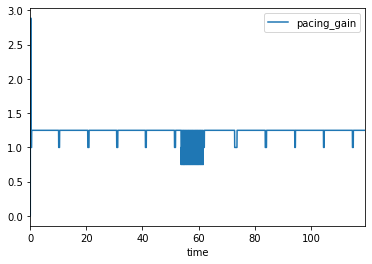

In [36]:
cols = ['bw','cwnd','cwnd_gain','pacing_gain','_mrtt']
for col in df.columns:
    if(col in cols):
        df[col] = df[col].astype(float)
df.plot(x='time',y='pacing_gain')

In [88]:
#Retorna um dataframe com as informacoes daquela pasta( HOST ) em especifico
data = []

def get_num(x):
    val = ''
    for ele in x:
        if(ele.isdigit() or ele == '.'):
            val += ele
        else:
            break
    return float(val)

def rate(val):
    number = get_num(val)
    if("K" in val):
        number *= 1000
    elif("M" in val):
        number *= 1000000
    elif("G" in val):
        number *= 1000000000
    return number

def to_secs(val):
    number = get_num(val)
    if("ms" in val):
        number *= 0.001
    return number
    
    
def format_columns(df):
    df['rate'] = df['rate'].apply(lambda x: rate(x) )
    df['backlog'] = df['backlog'].apply(lambda x: rate(x) )
    df['burst'] = df['burst'].apply(lambda x: rate(x) )
    
    df['delay'] = df['delay'].apply(lambda x: to_secs(x) )
    df['lat'] = df['lat'].apply(lambda x: to_secs(x) )
    
    return df.fillna(0)


def queueParser(path):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and "Queue" in f ]
    
    for file in onlyfiles:
        id = 1
        f = open(path+"/"+file,"r")
        
        start = -1
        
        for line in f:
            #Parser nos dados coletados do netem
            data_json = {}
            words_netem = ['limit','delay','loss','backlog']
            words_tbf   = ['rate','burst','lat']
            line = line.split(" ")
            var = False
            for i in range(len(line)):
                if(line[i] in words_netem or line[i] in words_tbf):
                    var = True
                    aux = {line[i]:line[i+1]}
                    try:
                        data_json.update(aux)
                    except:
                        data_json = aux
                    
            if(var):
                data_json.update({"ip":line[0]})
                time = line[-1].split(":")
                time_s = float(time[0])*60 + float(time[1]) + 0.001*float(time[2][:-1])
                if(start == -1):
                    start = time_s
                data_json.update({"time":time_s - start}) 
                data_json.update({"id":id})
                id = id + 1
                data.append(data_json)
#     df_aux = pd.DataFrame.from_dict(json_normalize(data_json), orient='columns')
    df = pd.DataFrame(data)
    return format_columns(df)
        


In [ ]:
rate("2Kb")

In [89]:
#???? Ter a coluna IP aqui seria interessante !, possibilidade?
df = queueParser("/home/rodrigoluna/Área de Trabalho/UFRJ/TCC/Framework/h4")

In [90]:
df

,rate,burst,lat,backlog,limit,delay,ip,time,id
0,20000000.0,15000.0,0.006,0.0,1000,0.04,10.0.0.4,0.000,1
1,20000000.0,15000.0,0.006,0.0,1000,0.04,10.0.0.4,0.014,2
2,20000000.0,15000.0,0.006,74.0,1000,0.04,10.0.0.4,0.027,3
3,20000000.0,15000.0,0.006,74.0,1000,0.04,10.0.0.4,0.040,4
4,20000000.0,15000.0,0.006,74.0,1000,0.04,10.0.0.4,0.053,5
...,...,...,...,...,...,...,...,...,...
5969,20000000.0,15000.0,0.006,0.0,1000,0.04,10.0.0.4,119.418,5970
5970,20000000.0,15000.0,0.006,0.0,1000,0.04,10.0.0.4,119.431,5971
5971,20000000.0,15000.0,0.006,0.0,1000,0.04,10.0.0.4,119.446,5972
5972,20000000.0,15000.0,0.006,0.0,1000,0.04,10.0.0.4,119.459,5973


In [ ]:
#Verificar onde os .csvs serão salvos
#Montar os plots basicos a partir dos CSVs
